In [14]:
import pandas as pd, torch, numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, log_loss, roc_auc_score, roc_curve
from tqdm.auto import trange
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          DataCollatorWithPadding, get_linear_schedule_with_warmup)
from torch.optim import AdamW
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train_raw = pd.read_csv('data/quora_train.csv.zip', index_col=0).dropna(subset=["question1", "question2"])
test_raw  = pd.read_csv('data/quora_test.csv.zip', index_col=0).dropna(subset=["question1", "question2"])

In [3]:
train_df, val_df = train_test_split(
    train_raw,
    test_size=0.15,                      
    stratify=train_raw["is_duplicate"],
    random_state=42,
)

In [4]:
print(f"Train: {len(train_df)}  Val: {len(val_df)}  Test: {len(test_raw)}")

Train: 274914  Val: 48515  Test: 80858


In [5]:
model_name = "bert-base-uncased"
tokenizer  = AutoTokenizer.from_pretrained(model_name)

In [6]:
class QQPDataset(Dataset):
    def __init__(self, df, tok, max_len=128):
        self.q1, self.q2, self.y = (
            df["question1"].tolist(),
            df["question2"].tolist(),
            df["is_duplicate"].tolist(),
        )
        self.tok, self.max_len = tok, max_len
    def __len__(self): return len(self.y)
    def __getitem__(self, i):
        enc = self.tok(
            self.q1[i], self.q2[i],
            truncation=True, max_length=self.max_len,
            padding=False, return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.y[i], dtype=torch.long)
        return item

In [13]:
data_collator = DataCollatorWithPadding(tokenizer)

batch = 8
train_loader = DataLoader(QQPDataset(train_df, tokenizer), batch, True,  collate_fn=data_collator)
val_loader   = DataLoader(QQPDataset(val_df,   tokenizer), batch, False, collate_fn=data_collator)
test_loader  = DataLoader(QQPDataset(test_raw, tokenizer), batch, False, collate_fn=data_collator)


In [8]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model   = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

epochs  = 3
total   = epochs * len(train_loader)
warmup  = int(0.1 * total)

opt      = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler= get_linear_schedule_with_warmup(opt, warmup, total)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
def display_metrics(y_true, y_pred, y_prob):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    ll = log_loss(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    print(f"Accuracy:      {acc:.4f}")
    print(f"Precision:     {prec:.4f}")
    print(f"Recall:        {rec:.4f}")
    print(f"F1 Score:      {f1:.4f}")
    print(f"Log Loss:      {ll:.4f}")
    print(f"ROC AUC:       {auc:.4f}")

def plot_confusion_matrix(y_true, y_pred, labels=None, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    cm_sum = cm.sum(axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float)
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            perc = cm_perc[i, j]
            count = cm[i, j]
            annot[i, j] = f"{perc:.2f}\n({count})"
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_perc, annot=annot, fmt='', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(title)
    plt.show()

def plot_roc_curve(y_true, y_prob, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = roc_auc_score(y_true, y_prob)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [10]:
def run_epoch(loader, train=True):
    model.train() if train else model.eval()

    probs, preds, y_true = [], [], []
    tot_loss = 0.0

    for batch in loader:
        batch = {k: v.to(device) for k, v in batch.items()}

        # --- forward (grad on/off automatically) ---
        with torch.set_grad_enabled(train):
            out    = model(**batch)
            loss   = out.loss
            logits = out.logits

        # --- backward + optimiser only when training ---
        if train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step(); scheduler.step(); opt.zero_grad()

        # --- accumulate loss ---
        tot_loss += loss.item() * batch["labels"].size(0)

        # --- collect predictions ---
        probs_batch = torch.softmax(logits, dim=1)[:, 1].detach().cpu().numpy()
        preds_batch = (probs_batch > 0.5).astype(int)

        probs.extend(probs_batch)
        preds.extend(preds_batch)
        y_true.extend(batch["labels"].cpu().numpy())

    # Return everything the outside world needs
    return {
        "loss"   : tot_loss / len(loader.dataset),  # average cross-entropy
        "y_true" : np.array(y_true),
        "y_pred" : np.array(preds),
        "y_prob" : np.array(probs),
    }

Epochs:   0%|          | 0/3 [00:00<?, ?epoch/s]

Accuracy:      0.8985
Precision:     0.8502
Recall:        0.8802
F1 Score:      0.8650
Log Loss:      0.3537
ROC AUC:       0.9619


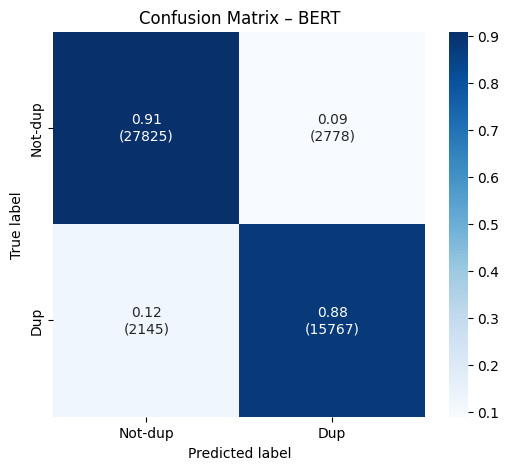

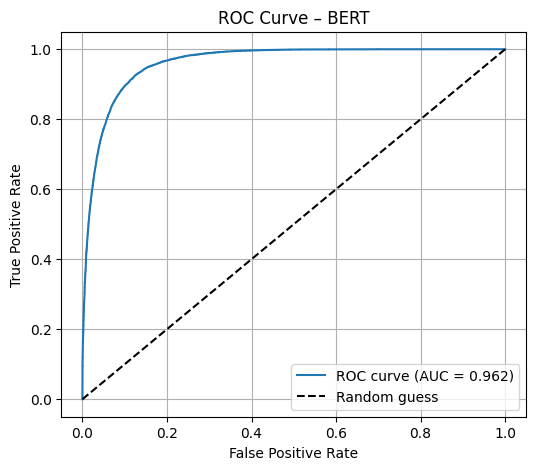

Accuracy:      0.8985
Precision:     0.8502
Recall:        0.8802
F1 Score:      0.8650
Log Loss:      0.3537
ROC AUC:       0.9619


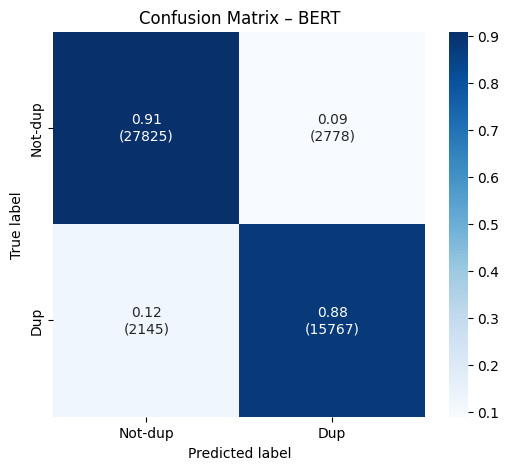

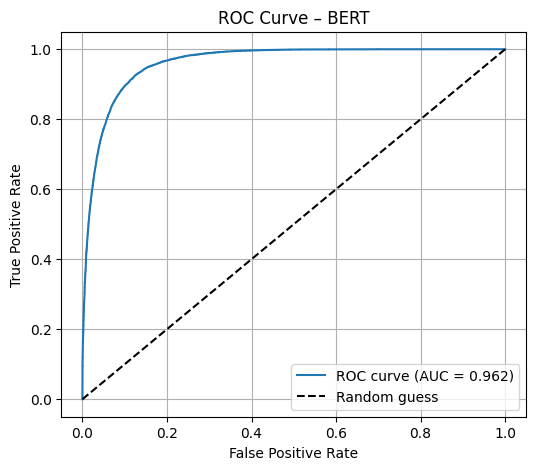

Early stopping triggered.


In [16]:
best_val_loss = float("inf")     
patience      = 2               
no_improve    = 0

epoch_bar = trange(1, epochs + 1, desc="Epochs", unit="epoch")

for ep in epoch_bar:

    # Run one full epoch
    tr_stats = run_epoch(train_loader, train=True)      # forward + back-prop
    va_stats = run_epoch(val_loader,   train=False)     # forward only

    # Grab the numbers 
    train_loss = tr_stats["loss"]                       # average CE on train set
    val_loss   = va_stats["loss"]                       # average CE on val set

    # Update the tqdm footer
    epoch_bar.set_postfix(
        train_loss=f"{train_loss:.4f}",
        val_loss  =f"{val_loss:.4f}"        
    )

    # Checkpointing + early stopping
    if val_loss < best_val_loss:          # improvement
        best_val_loss = val_loss
        no_improve    = 0
        torch.save(model.state_dict(), "bert_finetuning_model.pt")
    else:                                 # no improvement
        no_improve += 1
        if no_improve >= patience:
            epoch_bar.write("Early stopping triggered.")
            break

    display_metrics(va_stats["y_true"], va_stats["y_pred"], va_stats["y_prob"])
    plot_confusion_matrix(va_stats["y_true"], va_stats["y_pred"],
                          labels=['Not-dup', 'Dup'],
                          title="Confusion Matrix – BERT")
    plot_roc_curve(va_stats["y_true"], va_stats["y_prob"],
                   title="ROC Curve – BERT")

C:\Users\Galyna\AppData\Local\Temp\ipykernel_22776\411122019.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("bert_best.pt"))



  FINAL TEST METRICS
Accuracy:      0.8988
Precision:     0.8478
Recall:        0.8849
F1 Score:      0.8659
Log Loss:      0.3515
ROC AUC:       0.9619


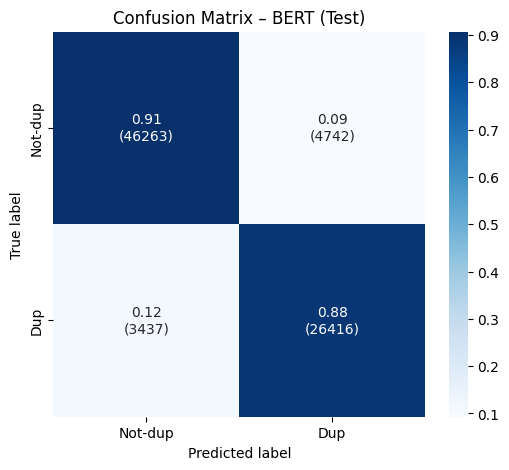

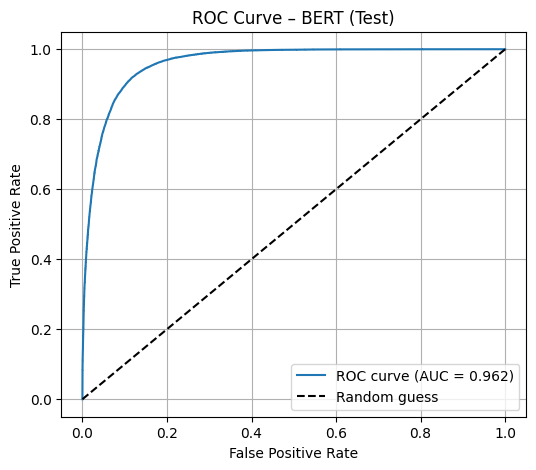

In [17]:
# Load the best model
model.load_state_dict(torch.load("bert_finetuning_model.pt"))

# Run on test set
te_stats = run_epoch(test_loader, train=False)

# Extract arrays
y_true = te_stats["y_true"]
y_pred = te_stats["y_pred"]
y_prob = te_stats["y_prob"]

# Display metrics and plots
print("\n  FINAL TEST METRICS")
display_metrics(y_true, y_pred, y_prob)
plot_confusion_matrix(y_true, y_pred, labels=['Not-dup', 'Dup'], title="Confusion Matrix – BERT (Test)")
plot_roc_curve(y_true, y_prob, title="ROC Curve – BERT (Test)")